## Overview

<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail</a> is a transnational dataset which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Source

UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/online+retail

## Business Goal

To segment the Customers based on RFM so that the company can target its customers efficiently.


## Methodology

1. [Reading and Understanding the Data](#1) <br>
   a. Creating a Data Dictionary
2. [Data Cleaning](#2)
3. [Data Preparation](#3) <br>
   a. Scaling Variables
4. [Model Building](#4) <br>
   a. K-means Clustering <br>
   b. Finding the Optimal K
5. [Final Analysis](#5)


<a id="1"></a> <br>

### 1 : Data Preprocessing


In [88]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly as py 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [89]:
# Reading the data on which analysis needs to be done
retail = pd.read_csv('dataset/OnlineRetail.csv', encoding='utf-8', encoding_errors='ignore')
# Display first 10 rows
retail.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


#### Data Dictionary

| First Header | Definition            | Description                                                                                                                        | Data Type |
| ------------ | --------------------- | ---------------------------------------------------------------------------------------------------------------------------------- | --------- |
| InvoiceNo    | Invoice number        | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. | Nominal   |
| StockCode    | Product (item) code   | A 5-digit integral number uniquely assigned to each distinct product.                                                              | Nominal   |
| Description  | Product (item) name   | Name of Product                                                                                                                    | Nominal   |
| Quantity     | Quantity              | The quantities of each product (item) per transaction                                                                              | Numeric   |
| InvoiceDate  | Invoice Date and time | The day and time when each transaction was generated.                                                                              | Numeric   |
| UnitPrice    | Unit price            | Product price per unit in sterling.                                                                                                | Numeric   |
| CustomerID   | Customer number       | A 5-digit integral number uniquely assigned to each customer.                                                                      | Nominal   |
| Country      | Country name          | The name of the country where each customer resides.                                                                               | Nominal   |


### Missing Values


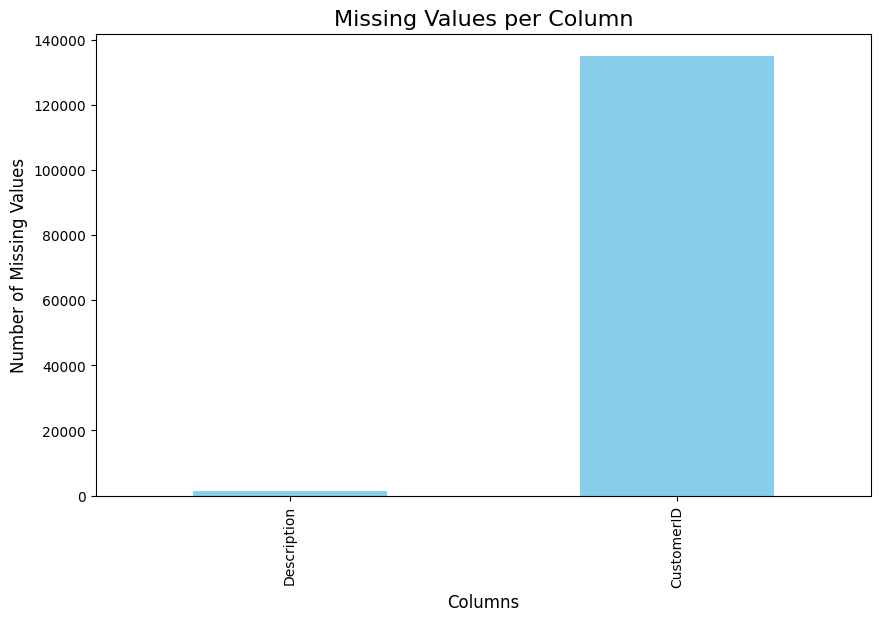

In [90]:
missing_values = retail.isnull().sum()

# Filter columns with missing values (optional, can remove if you want all columns)
missing_values = missing_values[missing_values > 0]

# Plot the missing values
plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Missing Values per Column', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Number of Missing Values', fontsize=12)

# Show the plot
plt.show()

As we can see, the majority of the missing values is in the Customer ID. Since Customer ID is a sensitive column, and we cannot make justifications o assumptions of the number of customers coming in to buy as it may cause some data inconsistencies and be the cause of misrepresentation of sensitive sales data, we drop the missing values.


In [91]:
# Dropping the null customer id rows
retail_cleaned = retail.copy()
retail_cleaned = retail_cleaned.dropna(subset=['CustomerID'])

We try to derive the meaning of the descriptions of the items using Stock Code, and try to fill in missing values


In [92]:
stock_code_to_description = retail_cleaned.dropna(subset=['Description']).set_index('StockCode')['Description'].to_dict()

# Fill missing descriptions using the dictionary
retail_cleaned['Description'] = retail_cleaned.apply(
    lambda row: stock_code_to_description.get(row['StockCode']) if pd.isnull(row['Description']) else row['Description'],
    axis=1
)

# Drop rows where the description is still missing
df_cleaned = retail_cleaned.dropna(subset=['Description'])

Check if missing values are no more


In [93]:
retail_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


<a id="2"></a> <br>

### 2 : Data Cleaning


In [94]:
# Calculating the Missing Values % contribution in DF
total_rows = len(retail)

# Calculate the number of missing values per column
missing_values = retail.isnull().sum()

# Calculate the percentage of missing values per column
missing_percentage = (missing_values / total_rows) * 100

# Filter only columns with missing values (optional, can remove if you want all columns)
missing_percentage = missing_percentage[missing_percentage > 0]

# Display the missing percentage for each column
missing_percentage = missing_percentage.sort_values(ascending=False)
print(missing_percentage)


CustomerID     24.926694
Description     0.268311
dtype: float64


In [95]:
# Changing the datatype of Customer Id as per Business understanding


<a id="3"></a> <br>

### 3 : Data Preparation


#### Customers will be analyzed based on 3 factors:

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)


In [96]:
retail_cleaned['InvoiceDate'] = pd.to_datetime(retail_cleaned['InvoiceDate'], format="%d-%m-%Y %H:%M", errors='coerce')

# Step 2: Compute the maximum date to determine the last transaction date
last_transaction_date = retail_cleaned['InvoiceDate'].max()
print(f"Last transaction date: {last_transaction_date}")

# Step 3: Compute Recency, Frequency, and Monetary for each customer
rfm = retail_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_transaction_date - x.max()).days,  # Recency: Days since last purchase
    'InvoiceNo': 'nunique',                                           # Frequency: Number of unique transactions
    'UnitPrice': lambda x: np.sum(x * retail_cleaned.loc[x.index, 'Quantity'])    # Monetary: Total spending per customer
}).reset_index()

# Step 4: Rename the columns to represent RFM
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Step 5: Display the resulting RFM table
print(rfm)

Last transaction date: 2011-12-09 12:50:00
      CustomerID  Recency  Frequency  Monetary
0        12346.0      325          2      0.00
1        12347.0        1          7   4310.00
2        12348.0       74          4   1797.24
3        12349.0       18          1   1757.55
4        12350.0      309          1    334.40
...          ...      ...        ...       ...
4367     18280.0      277          1    180.60
4368     18281.0      180          1     80.82
4369     18282.0        7          3    176.60
4370     18283.0        3         16   2094.88
4371     18287.0       42          3   1837.28

[4372 rows x 4 columns]


In [97]:
# Merging the two dfs
retail_final = pd.merge(retail_cleaned, rfm, on='CustomerID', how='inner')  # You can change 'how' to 'outer', 'left', or 'right' as needed

# Display the first few rows of the merged DataFrame
print(retail_final.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Recency  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom      301   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom      301   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom      301   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom      301   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom      301   

   Frequency  Monetary  
0         35   5288.63  
1         35   5288.63  
2         35   5288.63  
3         35   5288.63  
4  

#### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.<br>
There are two common ways of rescaling:

1. Min-Max scaling
2. Standardization (mean-0, sigma-1)

Here we execute Standard Scaling.


In [98]:
# Rescaling the attributes
from sklearn.preprocessing import MinMaxScaler
features = ['Monetary', 'Frequency', 'Recency']  
X = retail_final[features]


## <span style="color: red;">Execute MinMax Scaling in the next box</span>


In [99]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = features

<a id="4"></a> <br>

### 4 : Clustering Analysis


### K-Means Clustering


K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.


In [100]:
# k-means with some arbitrary k
Kmeans = KMeans(n_clusters=4, max_iter=50)
Kmeans.fit(X_scaled)

KMeans(max_iter=50, n_clusters=4)

### Optimal Number of Clusters

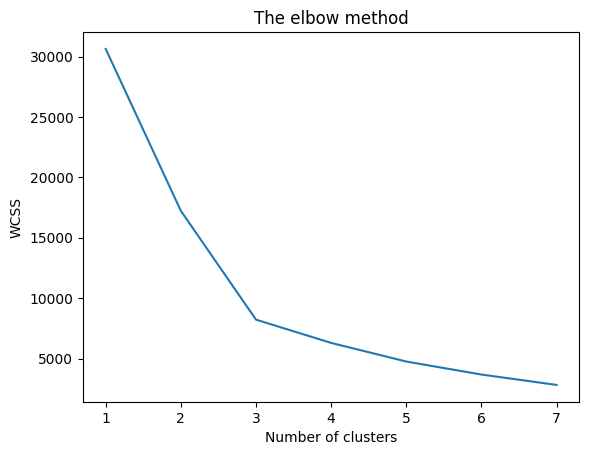

In [101]:
wcss = []

for i in range (1,8):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter=300, n_init=7, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,8), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [102]:
#create a K_means function here
def K_Mean(X, n):
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    model = KMeans(n)
    model.fit(X)
    clusters = model.predict(X)
    cent = model.cluster_centers_
    return (clusters, cent)

In [103]:
clusters, cent = K_Mean(X_scaled, 3)
kmeans = pd.DataFrame(clusters)
retail_final.insert((retail_final.shape[1]), 'kmeans', kmeans)
retail_final.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Recency,Frequency,Monetary,kmeans
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,301,35,5288.63,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,301,35,5288.63,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,301,35,5288.63,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,301,35,5288.63,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,301,35,5288.63,2


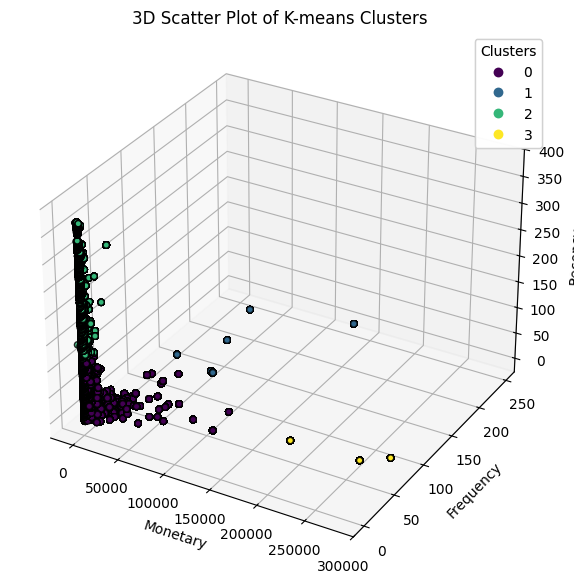

In [104]:
#plot your clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Use the cluster column to color the points
scatter = ax.scatter(retail_final[features[0]], retail_final[features[1]], retail_final[features[2]], 
                     c=retail_final['kmeans'], cmap='viridis', marker='o', edgecolor='k')

# Set labels for the axes
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])

# Add a color bar to show cluster labels
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# Add a title
plt.title('3D Scatter Plot of K-means Clusters')

# Show the plot
plt.show()

## <span style="color: red;">Box Plots of Clusters created</span>


<a id="5"></a> <br>

## Step 5 : Final Analysis


## <span style="color: red;">Findings</span>


#### Student Name:
